In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.signal import square
import math
from numpy.fft import fft, ifft, fftfreq
import time

In [2]:
class MyPlotter:
    def __init__(self, size : tuple, fontsize=12, **kwargs):
        self.fig, self.axs = plt.subplots(*size, **kwargs)
        self.fontsize = fontsize
        
    def plot(self, ax_idx : tuple, x, y, title=None, xlabel=None, ylabel=None, xlim=None, ylim=None, grid : bool = False, **kwargs):
        self.axs[ax_idx].plot(x, y, **kwargs)
        if title is not None:
            self.axs[ax_idx].set_title(title, fontsize=self.fontsize)
        if xlabel is not None:
            self.axs[ax_idx].set_xlabel(xlabel, fontsize=self.fontsize)
        if ylabel is not None:
            self.axs[ax_idx].set_ylabel(ylabel, fontsize=self.fontsize)
        if xlim is not None: 
            self.axs[ax_idx].set_xlim(xlim)
        if ylim is not None:
            self.axs[ax_idx].set_ylim(ylim)
        if grid: 
            self.axs[ax_idx].grid()
            
            
def cosinus(t, frequency, amplitude):
    w = frequency * 2 * np.pi
    return np.cos(w * t) * amplitude

def gauss_noise(signal, noise_level):
    return signal + np.random.standard_normal(signal.shape) * noise_level


In [3]:
def convolution(input_signal, kernel):
    # Получаем размеры сигнала и ядра
    signal_len = len(input_signal)
    kernel_len = len(kernel)
    output_len = signal_len + kernel_len - 1
    output = np.zeros(output_len)
    kernel = np.flip(kernel)
    for i in range(output_len):
        for j in range(kernel_len):
            if 0 <= i - j < signal_len:
                output[i] += input_signal[i - j] * kernel[j]
    
    return output

In [4]:
sample_rate = 1000.0  
duration = 1.0 
num_samples = int(sample_rate * duration)
timeline = np.linspace(0, duration, num_samples, endpoint=False)
freq_line = fftfreq(num_samples, 1 / sample_rate)

signal = cosinus(timeline, 50, 4)

# 1 kernel
kernel_exp = 1 * np.exp(-timeline**2)

# 2 kernel 
kernel_linear = 4 * timeline + 1

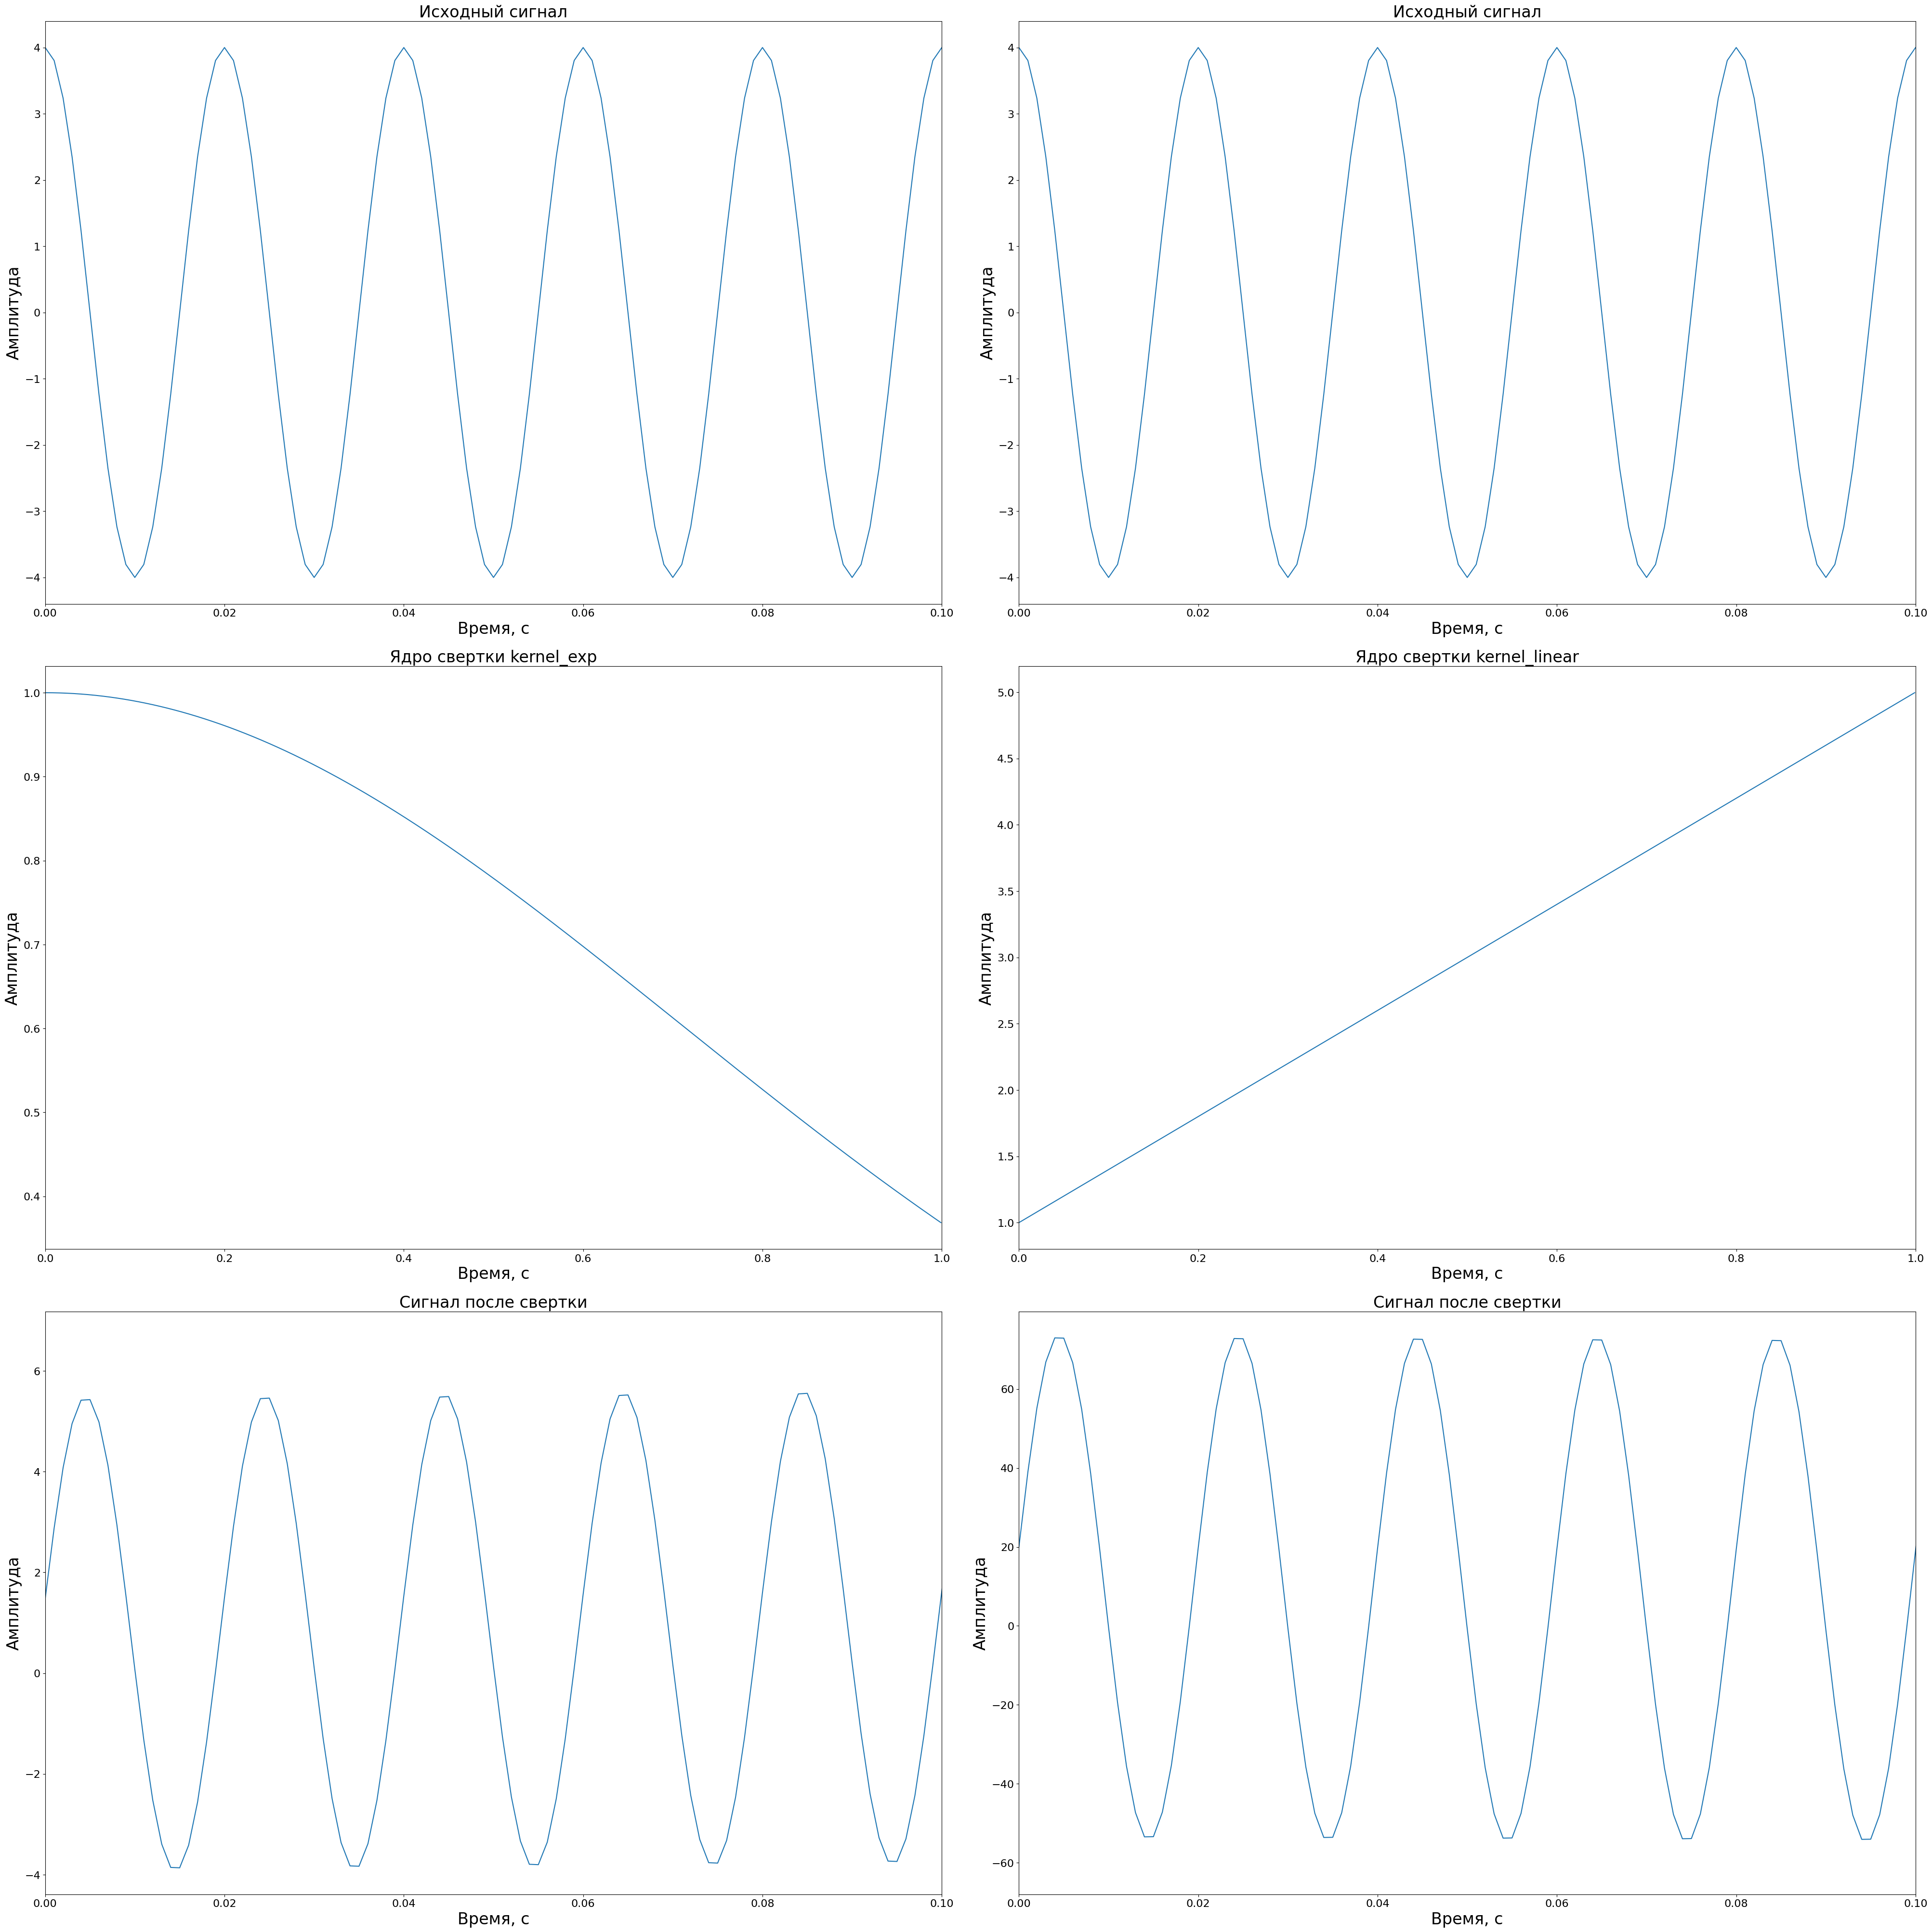

In [5]:
plt.rcParams.update({'font.size': 16})
plotter = MyPlotter((3, 2), figsize=(40, 40), layout="constrained", fontsize=24)

plotter.plot((0, 0), timeline, signal,
             title="Исходный сигнал",
             xlabel="Время, с", 
             ylabel="Амплитуда",
             xlim=[0, 0.1]) 

plotter.plot((1, 0), timeline, kernel_exp,
             title="Ядро свертки kernel_exp",
             xlabel="Время, с", 
             ylabel="Амплитуда",
             xlim=[0, 1]) 

plotter.plot((2, 0), timeline, convolution(signal, kernel_exp)[0: len(timeline)],
             title="Сигнал после свертки",
             xlabel="Время, с", 
             ylabel="Амплитуда",
             xlim=[0, 0.1]) 



plotter.plot((0, 1), timeline, signal,
             title="Исходный сигнал",
             xlabel="Время, с", 
             ylabel="Амплитуда",
             xlim=[0, 0.1]) 

plotter.plot((1, 1), timeline, kernel_linear,
             title="Ядро свертки kernel_linear",
             xlabel="Время, с", 
             ylabel="Амплитуда",
             xlim=[0, 1]) 

plotter.plot((2, 1), timeline, convolution(signal, kernel_linear)[0: len(timeline)],
             title="Сигнал после свертки",
             xlabel="Время, с", 
             ylabel="Амплитуда",
             xlim=[0, 0.1]) 

plt.show()

In [6]:
sample_rate = 1000.0  
duration = 1.0 
num_samples = int(sample_rate * duration)
timeline = np.linspace(0, duration, num_samples, endpoint=False)
freq_line = fftfreq(num_samples, 1 / sample_rate)
dt = timeline[1] - timeline[0]

signal = cosinus(timeline, 50, 4)

# 1 kernel
kernel_exp = 1 * np.exp(-timeline**2)

# Time domain
# convolved_signal = convolution(signal, kernel_exp)[0:len(timeline)] / dt
convolved_signal = np.convolve(signal, kernel_exp, mode="same")
spectrum_time_domain = fft(convolved_signal)

# Frequency domain
spectrum_freq_domain = fft(kernel_exp) * fft(signal)

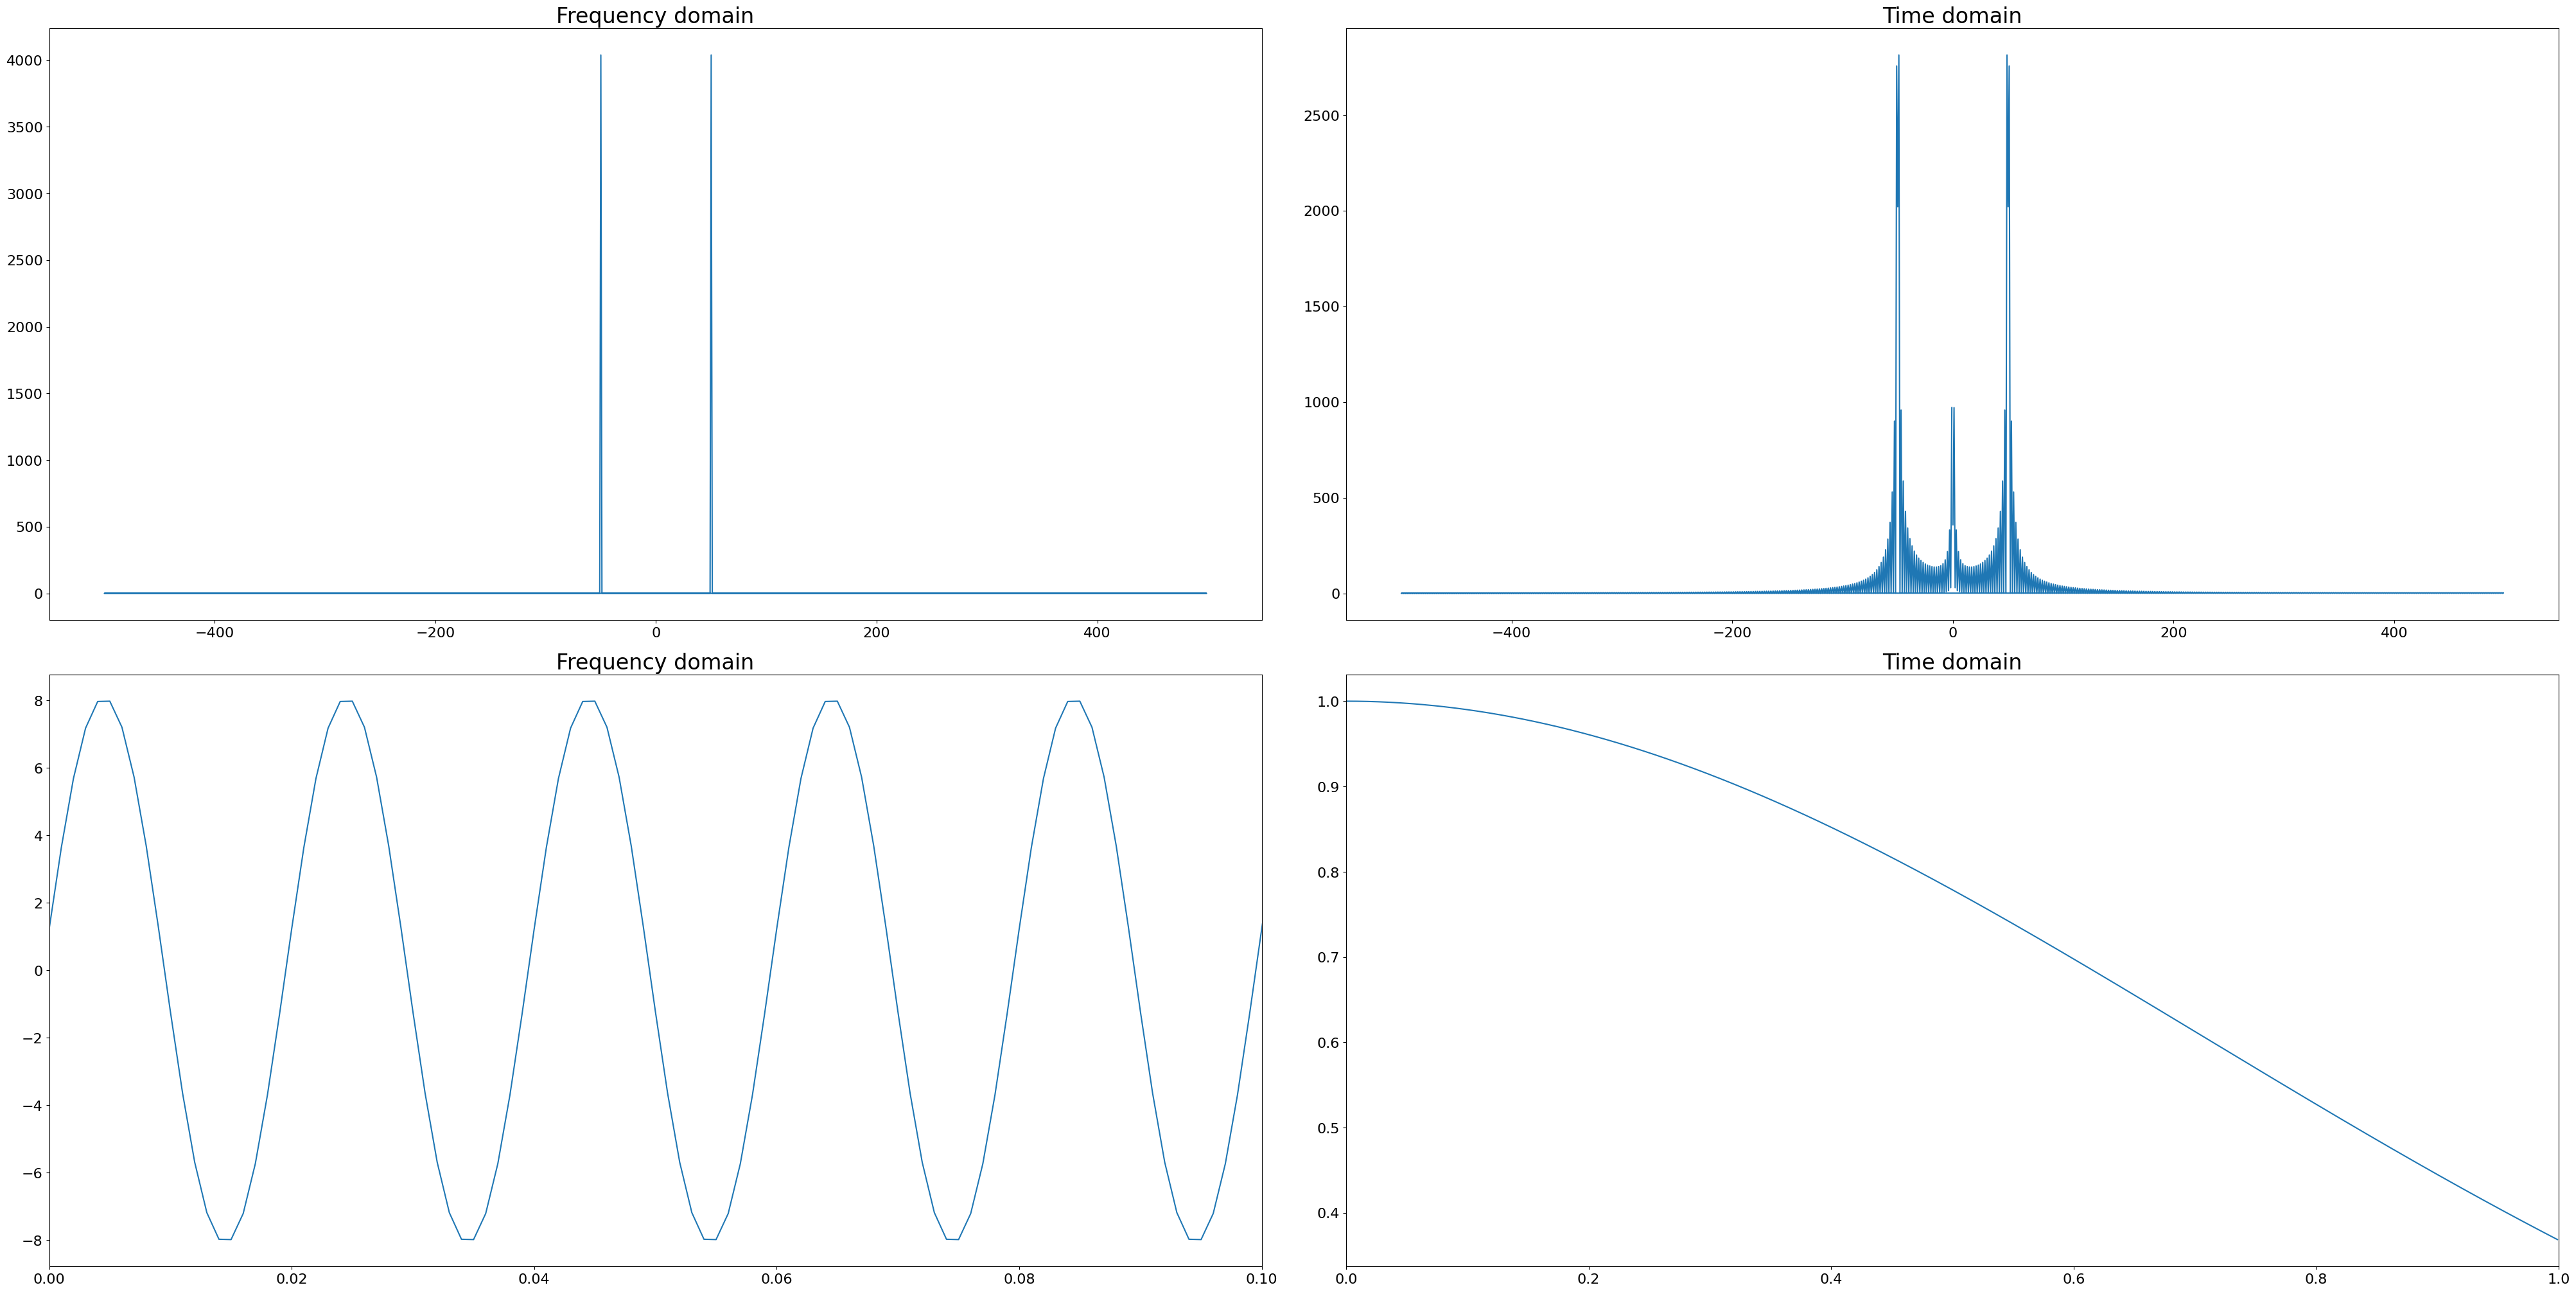

In [7]:
plt.rcParams.update({'font.size': 16})
plotter = MyPlotter((2, 2), figsize=(40, 20), layout="constrained", fontsize=24)

plotter.plot((0, 0), freq_line, np.abs(spectrum_freq_domain),
             title="Frequency domain",)

plotter.plot((0, 1), freq_line, np.abs(spectrum_time_domain),
             title="Time domain",)

plotter.plot((1, 0), timeline, np.real(ifft(spectrum_freq_domain)),
             title="Frequency domain",
             xlim=[0, 0.1])

plotter.plot((1, 1), timeline, kernel_exp, 
             title="Time domain",
             xlim=[0, 1])

plt.show()

In [8]:
def calculate_gaussian_kernel(length, peak_frequency, fwhm):
    frequencies = np.arange(length)
    s = fwhm / (2 * np.sqrt(2 * np.log(2)))
    # s = fwhm * (2 * np.pi - 1) / (4 * np.pi)
    gaussian = np.exp(-0.5 * ((frequencies - peak_frequency) / s) ** 2)
    
    return gaussian / np.sum(gaussian)


frequency_range = [0, 450]
peak_frequency = 150
fwhm = 50

timeline = np.linspace(0, duration, num_samples, endpoint=False)
freq_line = fftfreq(num_samples, 1 / sample_rate) 
signal = cosinus(timeline, 50, 4) + cosinus(timeline, 150, 4) + cosinus(timeline, 450, 4)

signal_spectrum = fft(signal)[0:num_samples//2]
gaussian_kernel = calculate_gaussian_kernel(len(signal_spectrum), peak_frequency, fwhm)
filtered_spectrum = np.multiply(signal_spectrum, gaussian_kernel)
filtered_signal = ifft(filtered_spectrum)


/home/ilyusha/Desktop/cos_exs/venv/lib/python3.10/site-packages/matplotlib/cbook.py:1698: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ilyusha/Desktop/cos_exs/venv/lib/python3.10/site-packages/matplotlib/cbook.py:1344: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


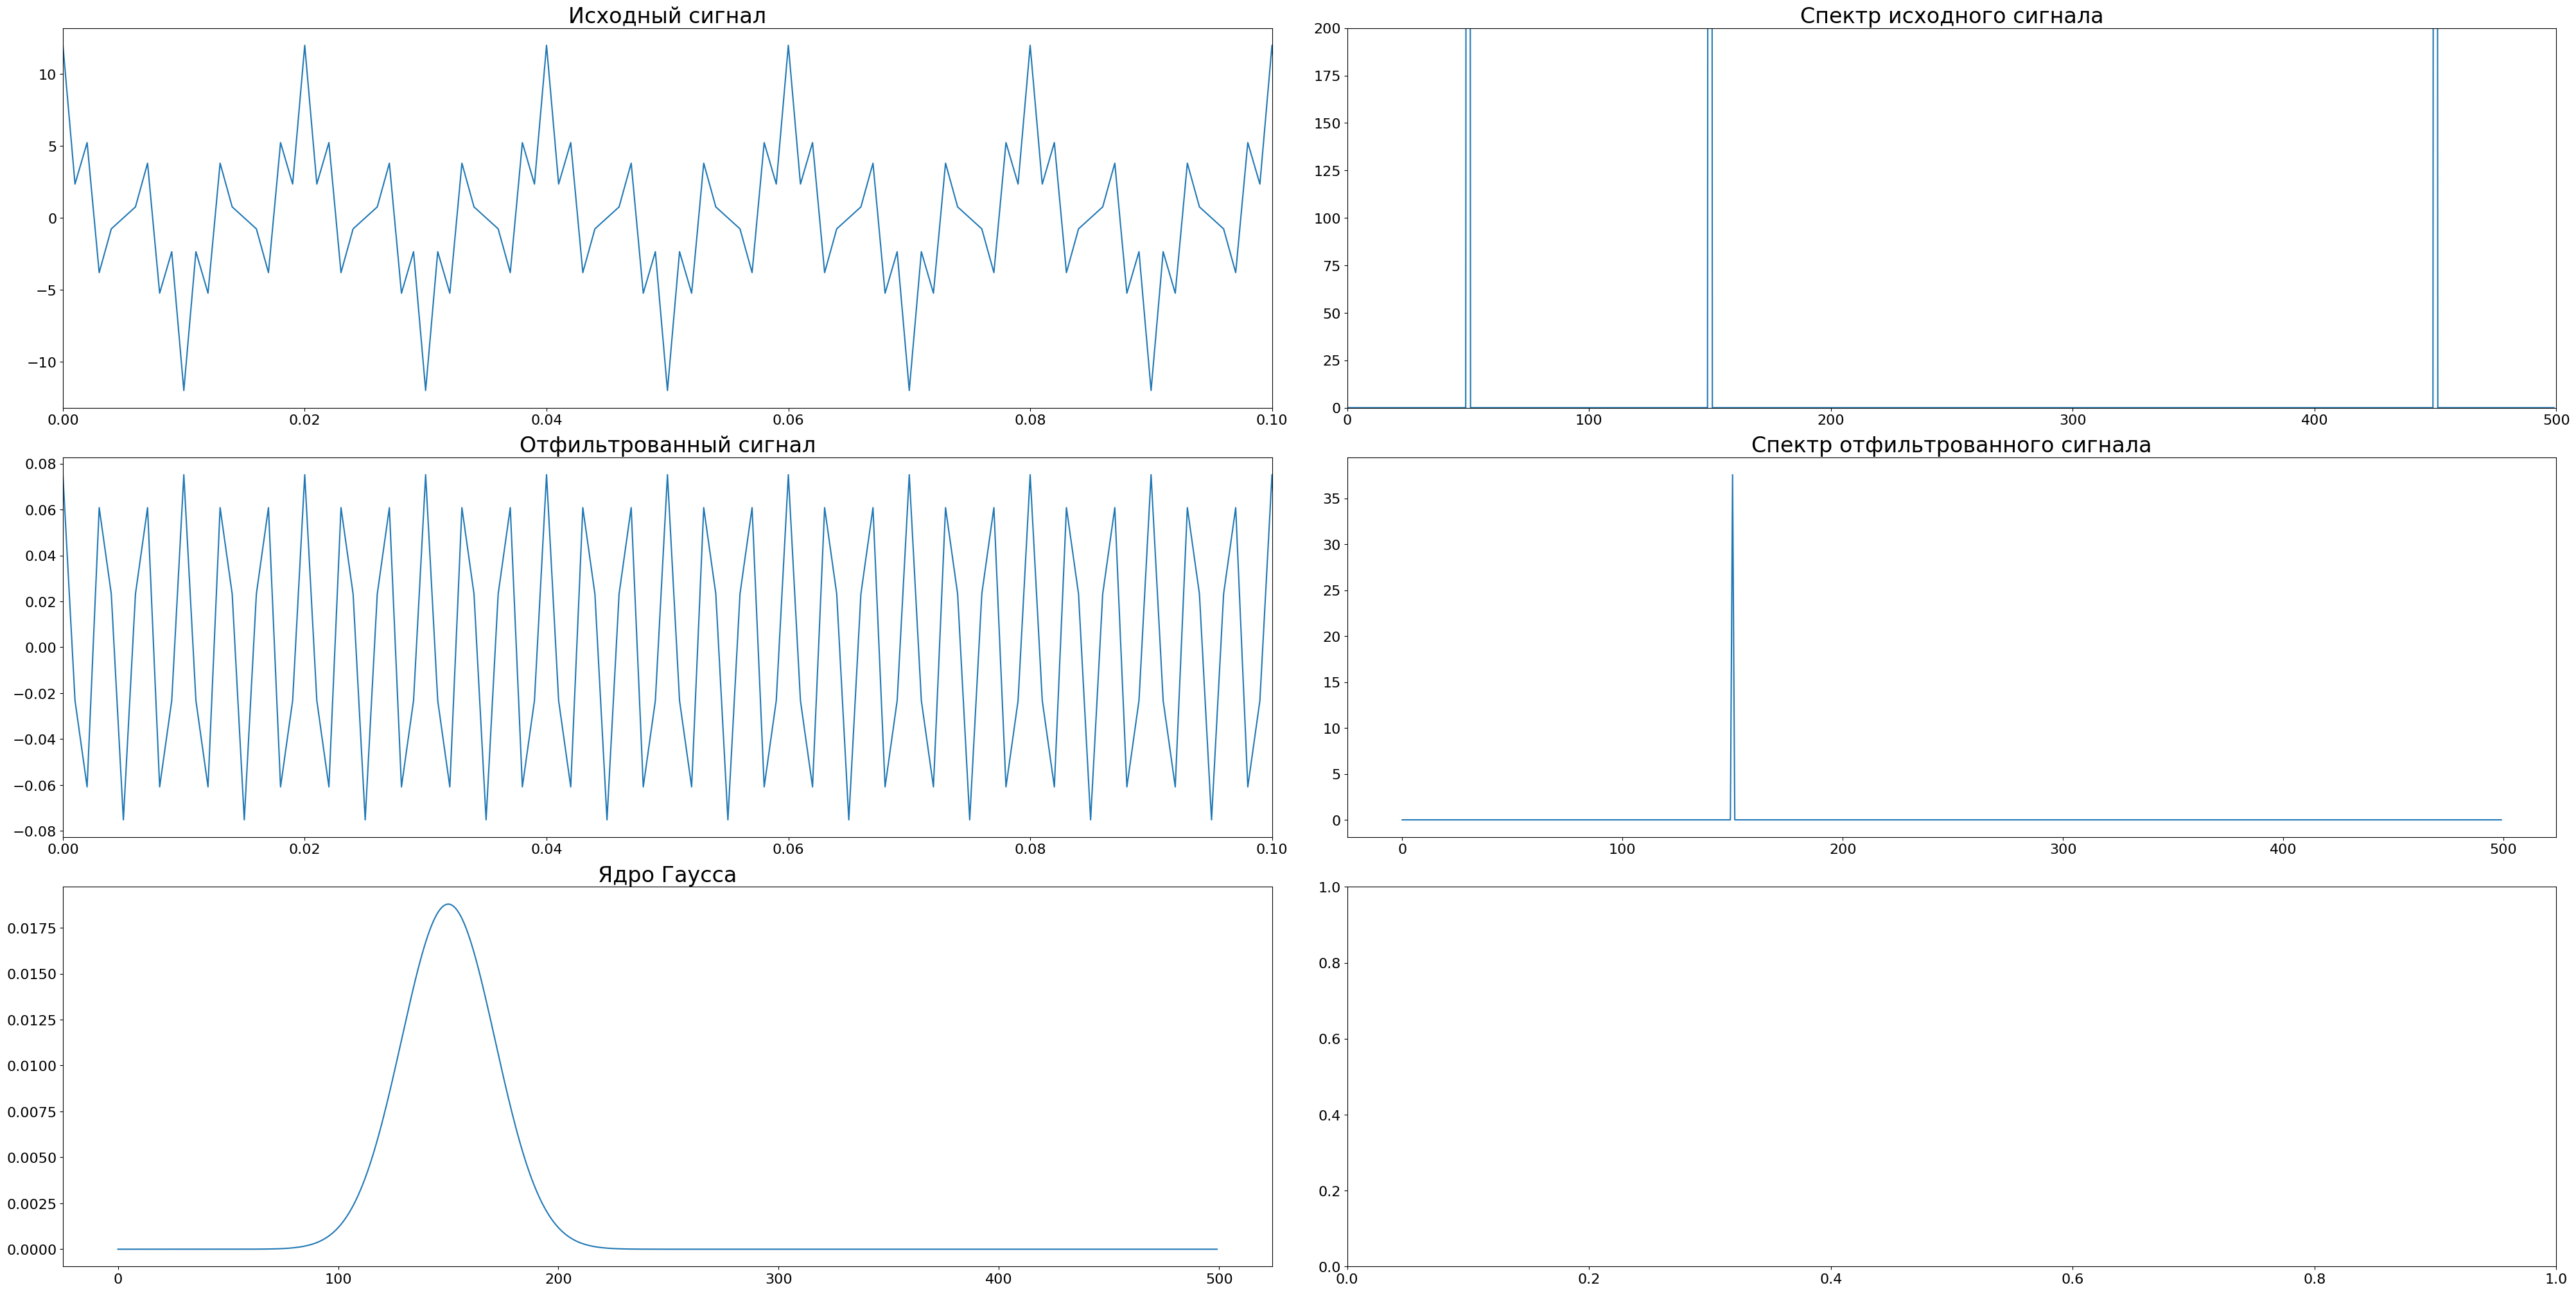

In [9]:
plt.rcParams.update({'font.size': 16})
plotter = MyPlotter((3, 2), figsize=(40, 20), layout="constrained", fontsize=24)

plotter.plot((0, 0), timeline, signal,
             title="Исходный сигнал",
             xlim=[0, 0.1])

plotter.plot((0, 1), freq_line[0:num_samples//2], np.abs(signal_spectrum),
             title="Спектр исходного сигнала",
             ylim=[0, 200],
             xlim=[0, 500])

plotter.plot((1, 0), timeline[0:num_samples//2], filtered_signal,
             title="Отфильтрованный сигнал",
             xlim=[0, 0.1])

plotter.plot((1, 1), freq_line[0:num_samples//2], np.abs(filtered_spectrum),
             title="Спектр отфильтрованного сигнала")

plotter.plot((2, 0), freq_line[0:num_samples//2], np.abs(gaussian_kernel),
             title="Ядро Гаусса")

plt.show()

Time domain 

In [10]:
gaussian_kernel = calculate_gaussian_kernel(500, peak_frequency, fwhm)
original_gaussian_kernel = gaussian_kernel[100:200]
filtered_signal = convolution(signal, original_gaussian_kernel)[0: len(timeline)] * (timeline[1] - timeline[0])
filtered_signal_spectrum = fft(filtered_signal)

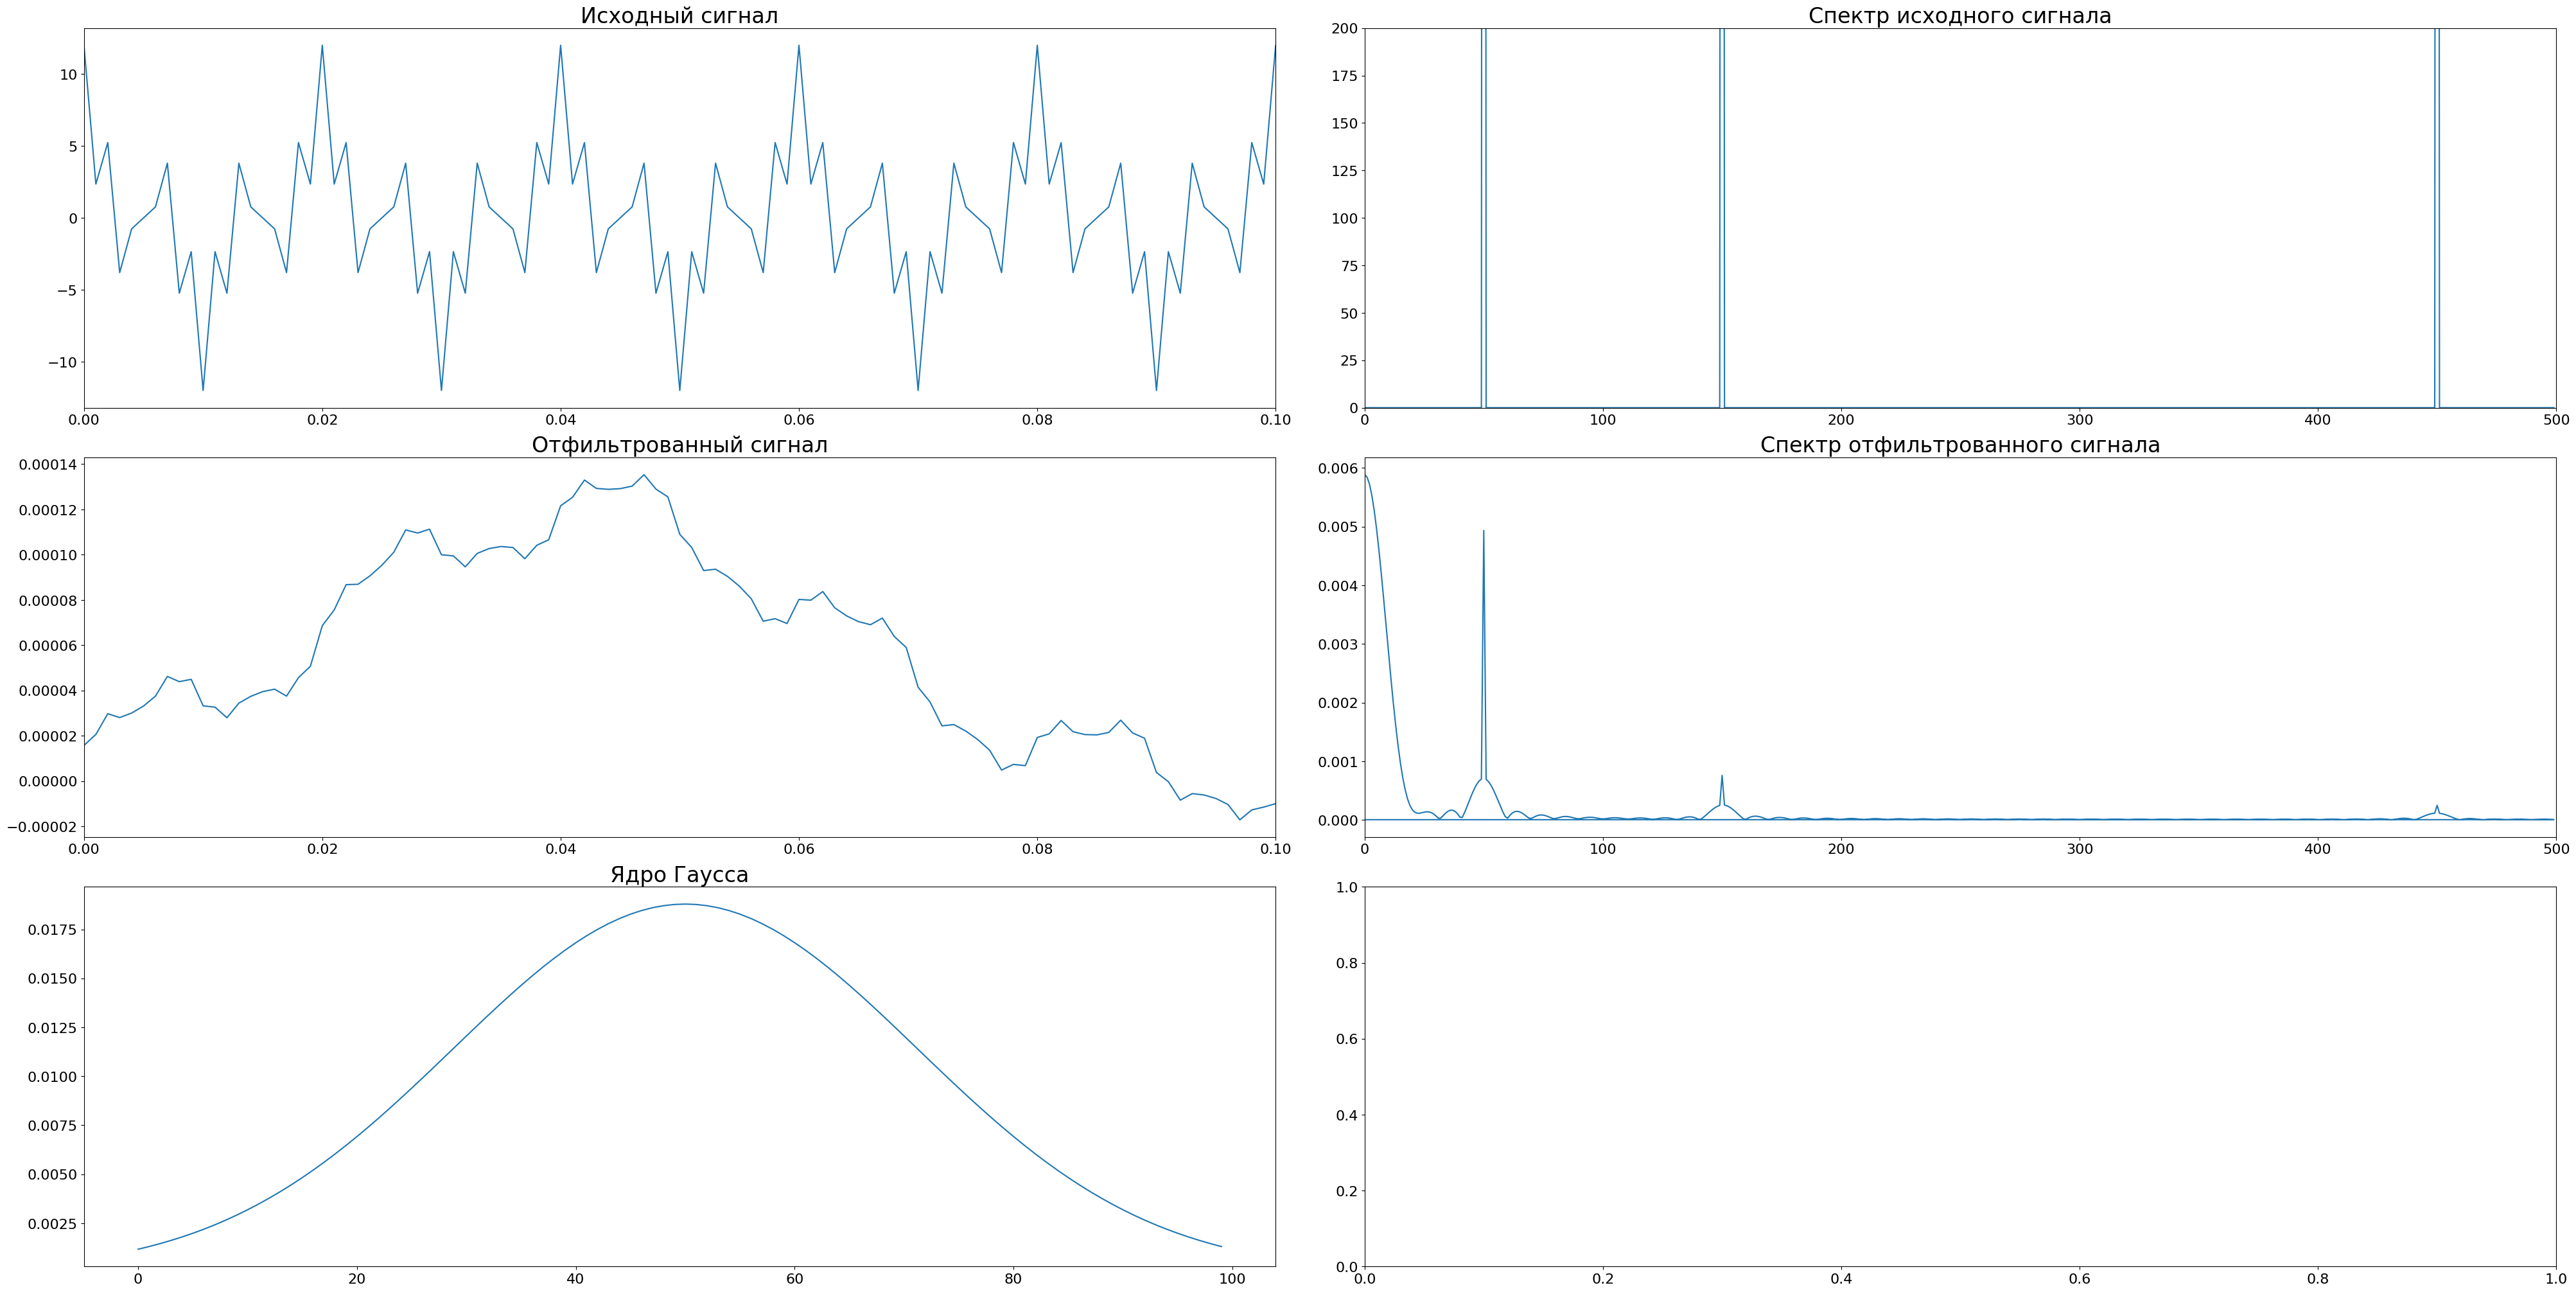

In [11]:
plt.rcParams.update({'font.size': 16})
plotter = MyPlotter((3, 2), figsize=(40, 20), layout="constrained", fontsize=24)

plotter.plot((0, 0), timeline, signal,
             title="Исходный сигнал",
             xlim=[0, 0.1])

plotter.plot((0, 1), freq_line[0: num_samples//2], np.abs(signal_spectrum),
             title="Спектр исходного сигнала",
             ylim=[0, 200],
             xlim=[0, 500])

plotter.plot((1, 0), timeline, filtered_signal,
             title="Отфильтрованный сигнал",
             xlim=[0, 0.1])

plotter.plot((1, 1), freq_line, np.abs(filtered_signal_spectrum),
             title="Спектр отфильтрованного сигнала",
             xlim=[0, 500])

plotter.plot((2, 0), freq_line[:len(original_gaussian_kernel)], np.abs(original_gaussian_kernel),
             title="Ядро Гаусса")

plt.show()

In [12]:
def calculate_planck_taper_window(e, domain):
    result = np.zeros_like(domain)
    N = len(domain)
    for i, k in enumerate(domain):
        if k == 0:
            result[i] = 0
        elif 0 < k < e * (N - 1):
            result[i] = 1 / (np.exp(e_z_a(N, e, k)) + 1)
        elif e * (N - 1) <= k <= (1 - e) * (N - 1):
            result[i] = 1
        elif (1 - e) * (N - 1) < k < N - 1:
            result[i] = 1 / (np.exp(e_z_b(N, e, k)) + 1)
        elif k == N - 1:
            result[i] = 0
    return result

def e_z_a(N, e, k):
    return e * (N - 1) * (1 / (k + 1) + 1 / (k - e * (N - 1)))

def e_z_b(N, e, k):
    return e * (N - 1) * (1 / (N - 1 - k) + 1 / ((1 - e) * (N - 1) - k))


signal = gauss_noise(signal, 0.5)

signal_spectrum = fft(signal)[:num_samples//2]
planck_taper_window = calculate_planck_taper_window(e=0.5, 
                                                    domain=freq_line[:num_samples//2])
filtered_spectrum = np.multiply(signal_spectrum, planck_taper_window)
band_filtered_signal = ifft(filtered_spectrum)

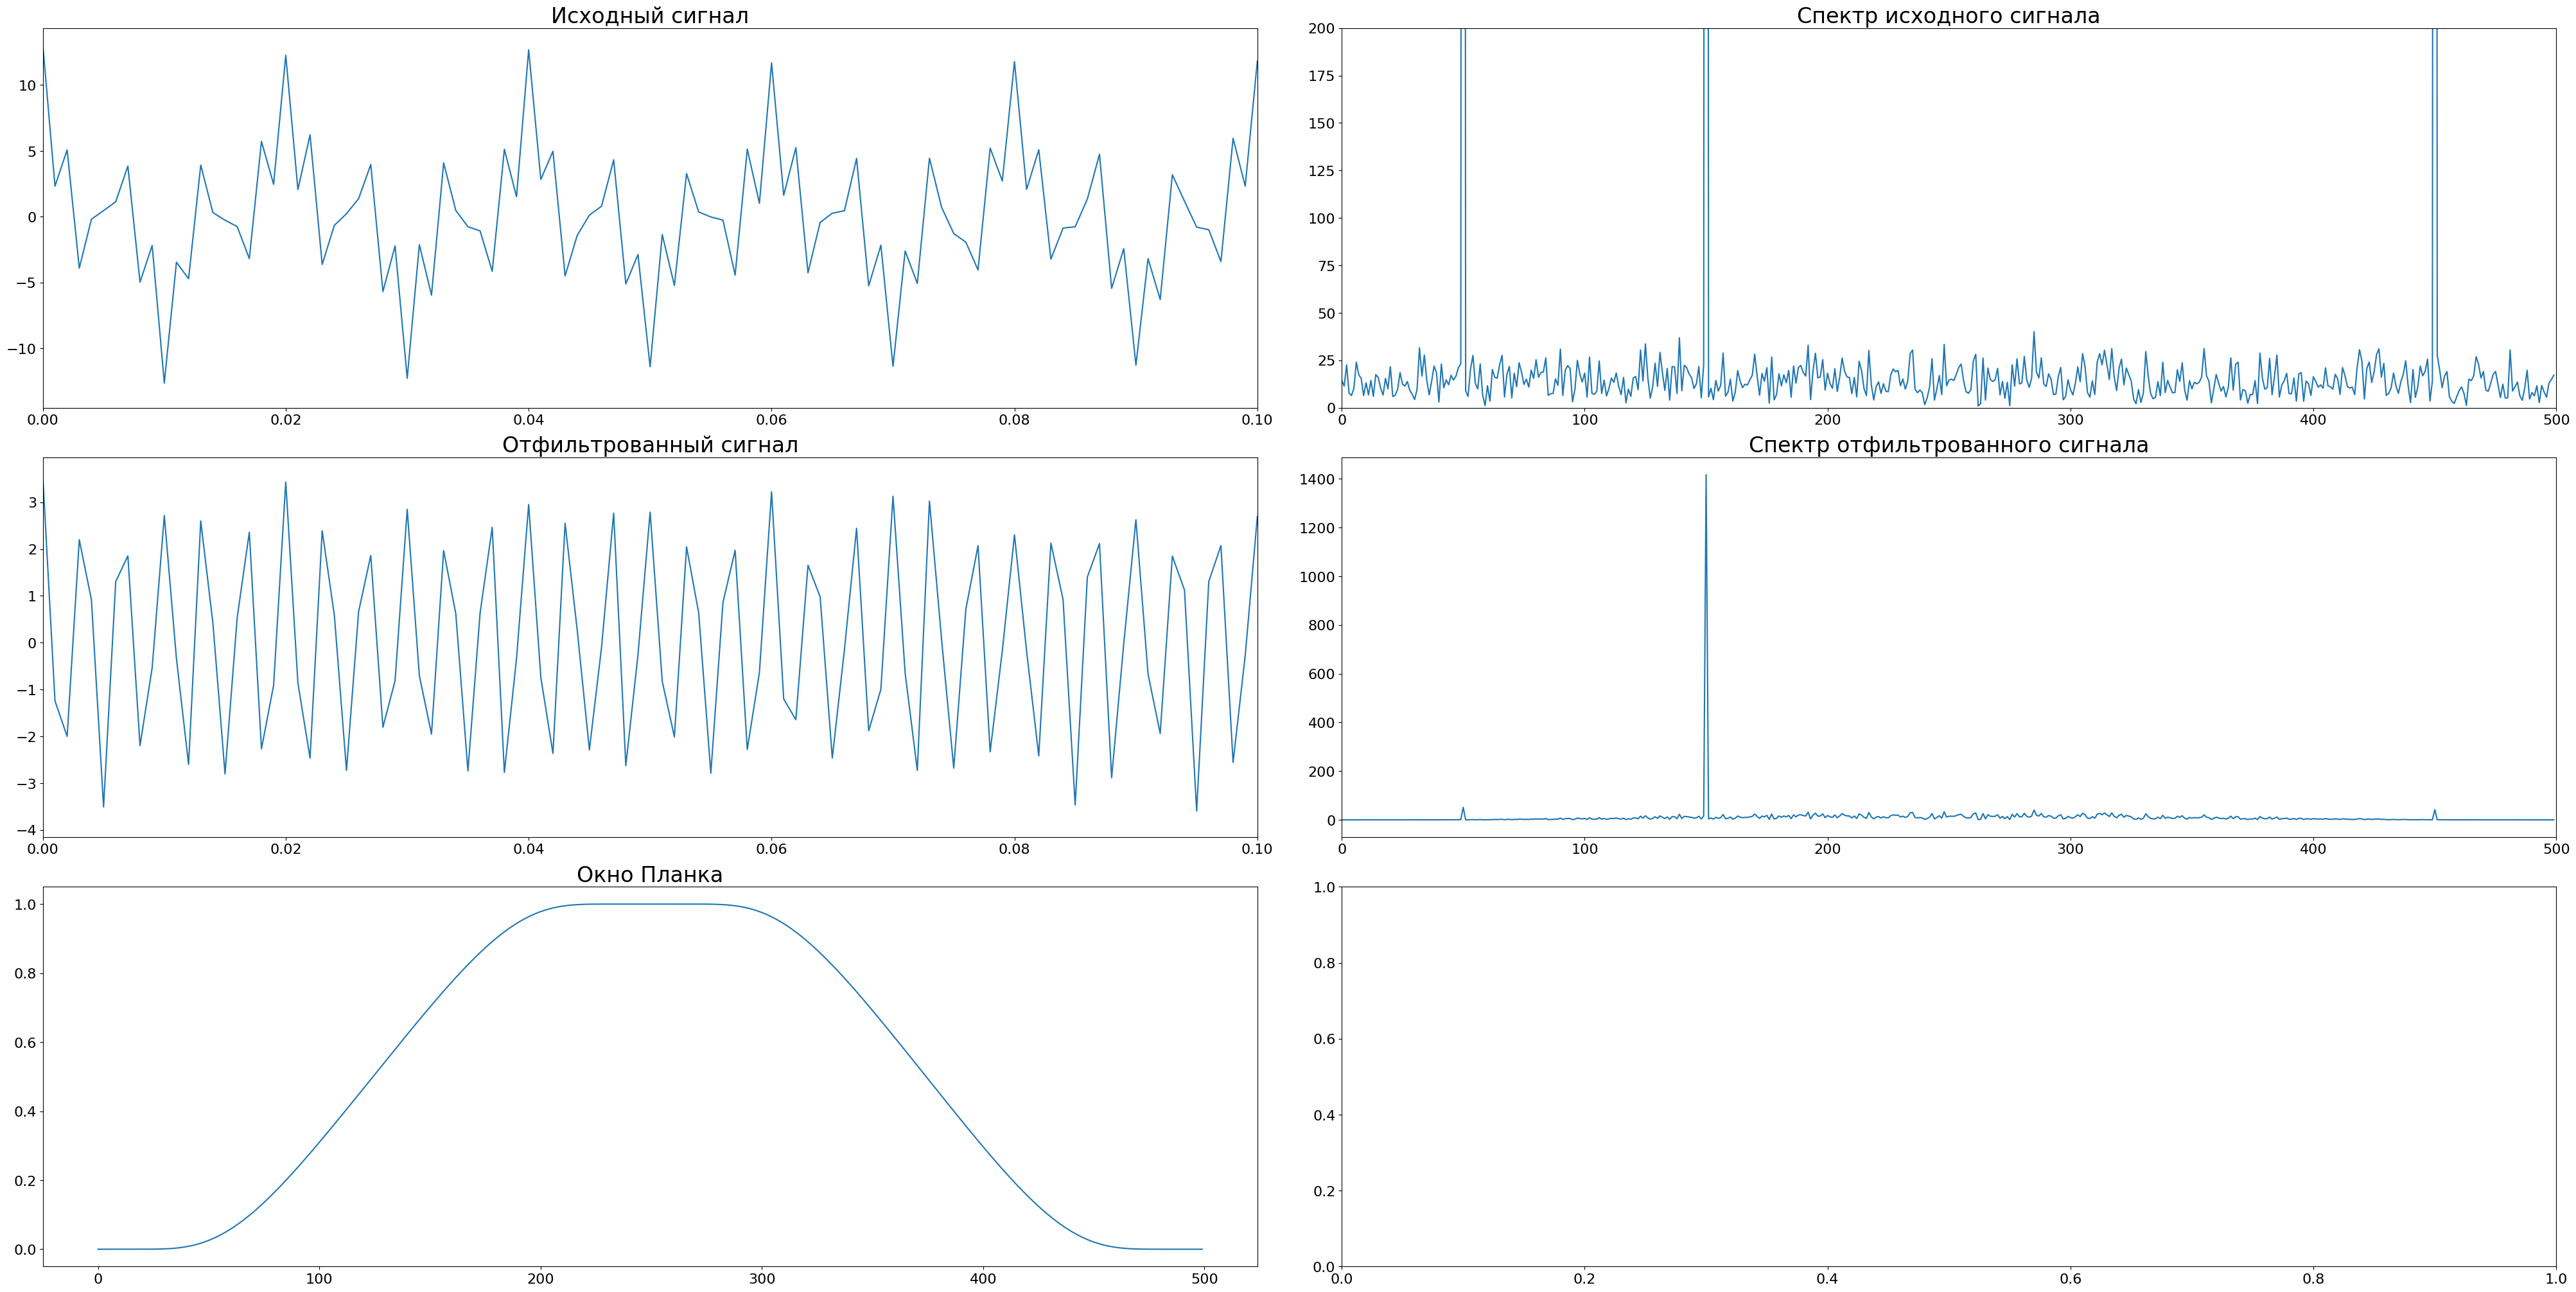

In [13]:
plt.rcParams.update({'font.size': 16})
plotter = MyPlotter((3, 2), figsize=(40, 20), layout="constrained", fontsize=24)

plotter.plot((0, 0), timeline, signal,
             title="Исходный сигнал",
             xlim=[0, 0.1])

plotter.plot((0, 1), freq_line[:num_samples//2], np.abs(signal_spectrum),
             title="Спектр исходного сигнала",
             ylim=[0, 200],
             xlim=[0, 500])

plotter.plot((1, 0), timeline[:num_samples//2], band_filtered_signal,
             title="Отфильтрованный сигнал",
             xlim=[0, 0.1])

plotter.plot((1, 1), freq_line[:num_samples//2], np.abs(filtered_spectrum),
             title="Спектр отфильтрованного сигнала",
             xlim=[0, 500])

plotter.plot((2, 0), freq_line[:num_samples//2], planck_taper_window,
             title="Окно Планка")

plt.show()

In [14]:
signal = gauss_noise(cosinus(timeline, 50, 4) + 
                     cosinus(timeline, 150, 4) + 
                     cosinus(timeline, 450, 4), noise_level=0.5)

signal_spectrum = fft(signal)[num_samples//2:]

planck_taper_kernel = calculate_planck_taper_window(e=0.4,
                                                    domain=freq_line[:num_samples//2])

gaussian_kernel = calculate_gaussian_kernel(length=num_samples//2,
                                            fwhm=200,
                                            peak_frequency=250)

planck_taper_filtered_spectrum = signal_spectrum * planck_taper_window

gaussian_kernel_filtered_spectrum = signal_spectrum * gaussian_kernel



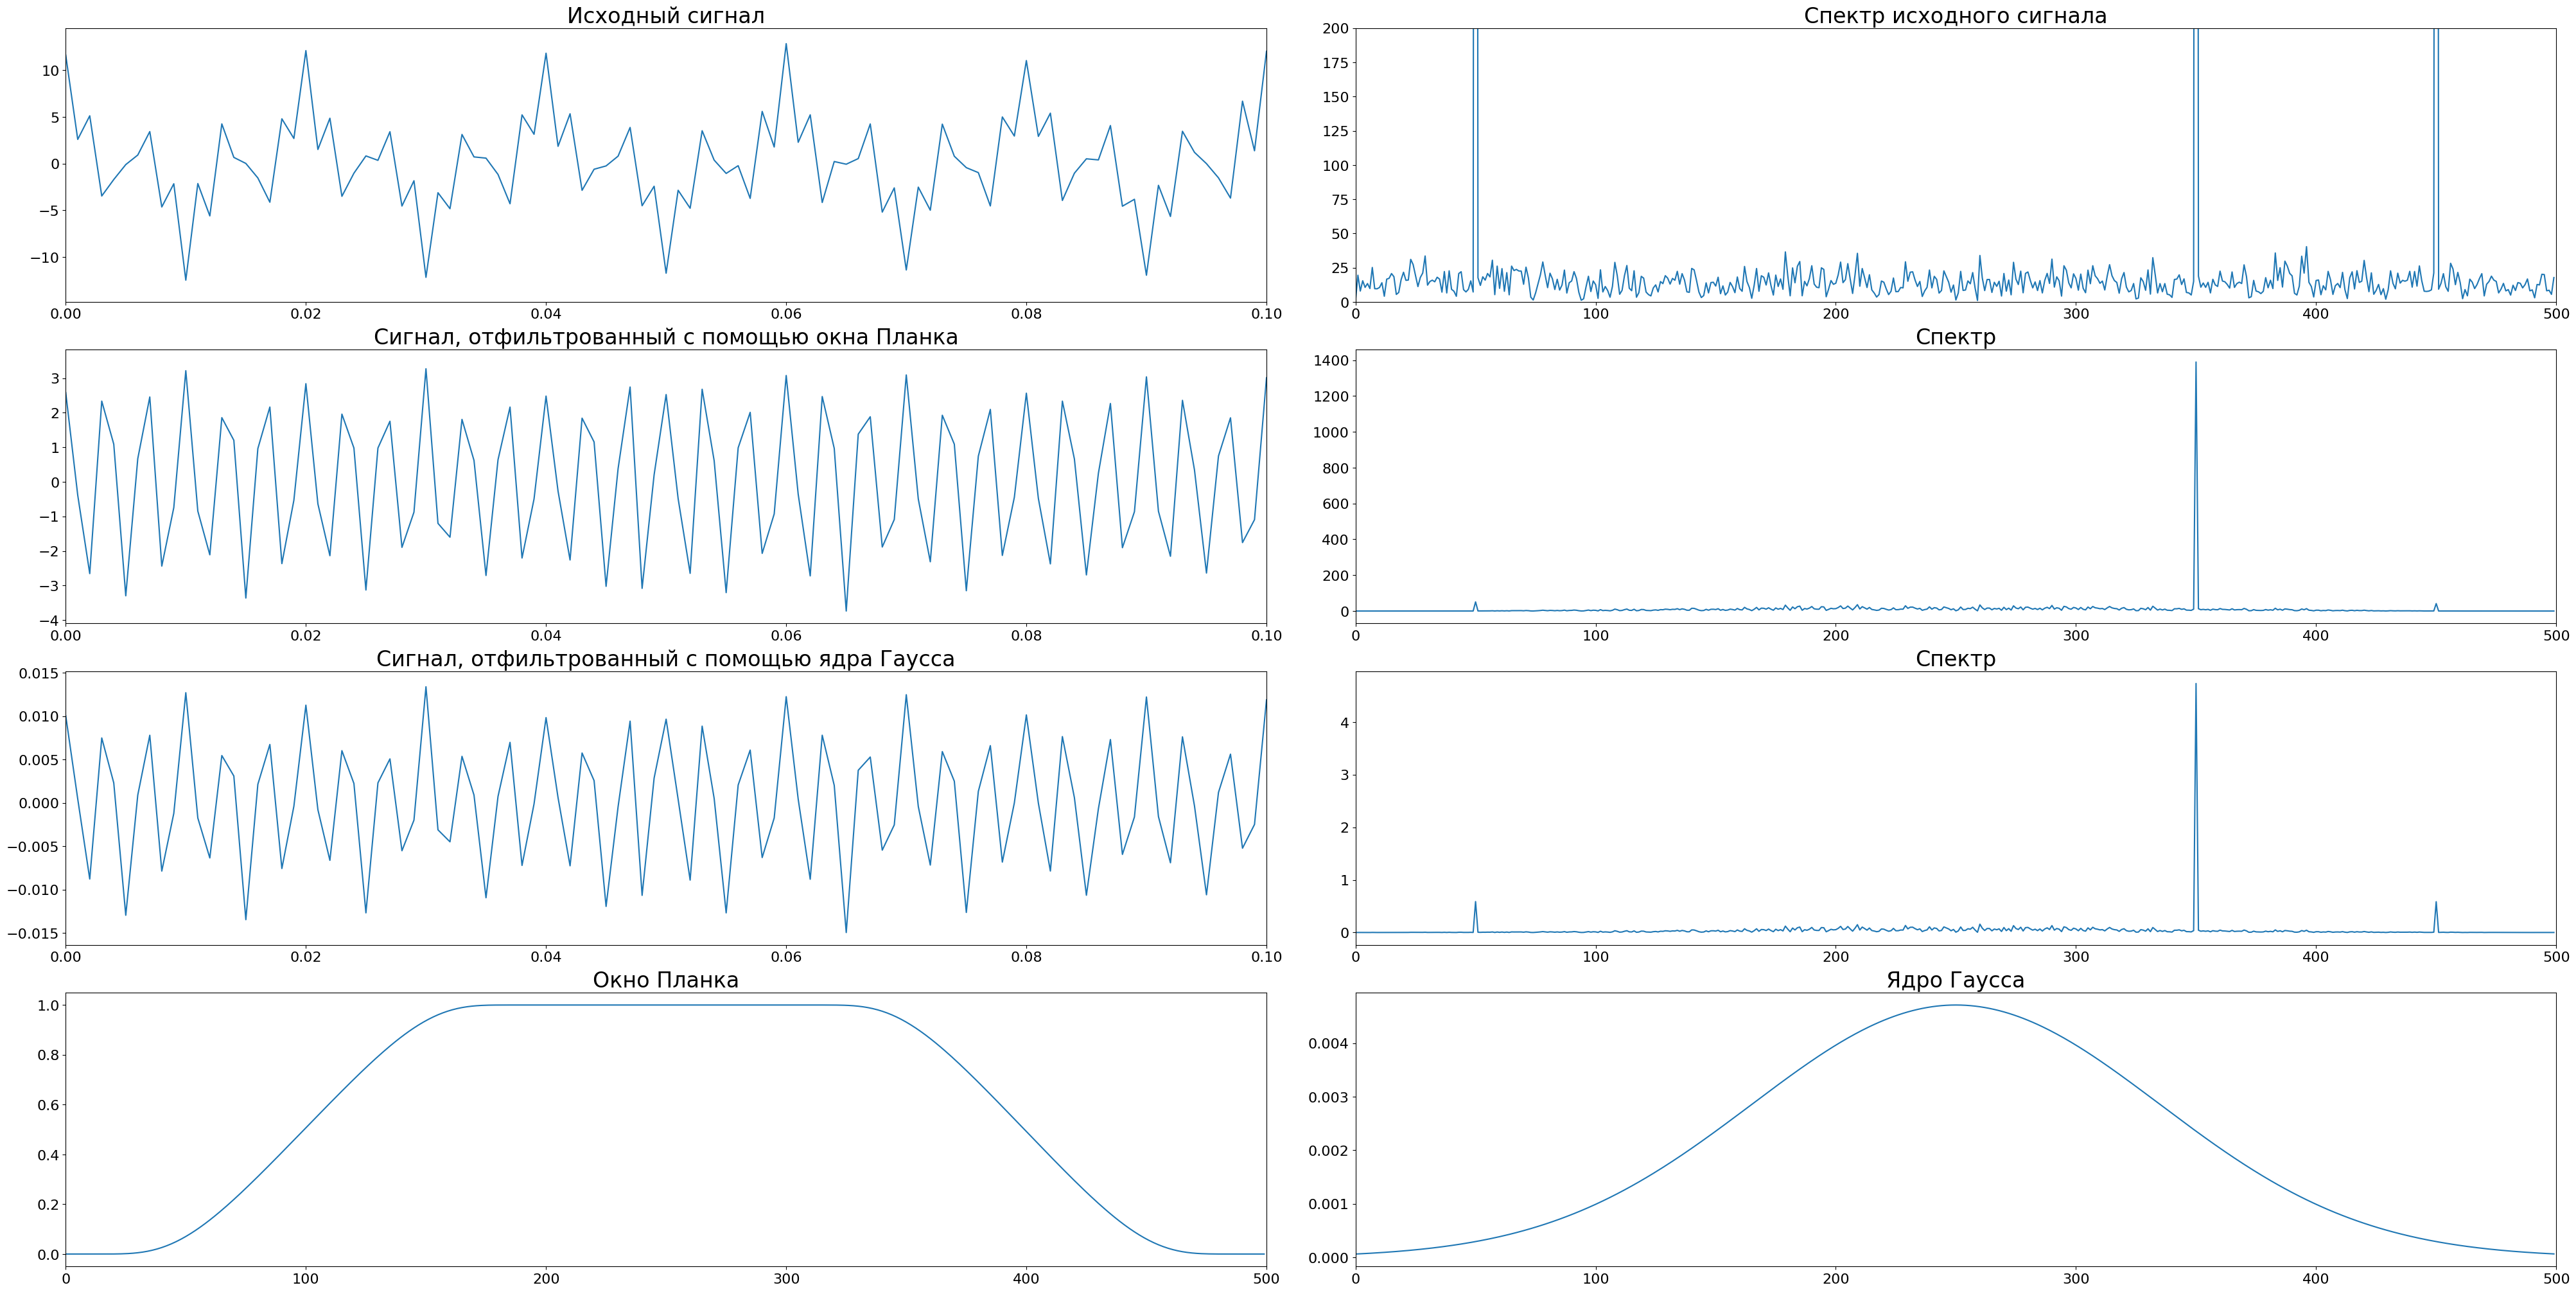

In [15]:
plt.rcParams.update({'font.size': 16})
plotter = MyPlotter((4, 2), figsize=(40, 20), layout="constrained", fontsize=24)

plotter.plot((0, 0), timeline, signal,
             title="Исходный сигнал",
             xlim=[0, 0.1])

plotter.plot((0, 1), freq_line[:num_samples//2], np.abs(signal_spectrum),
             title="Спектр исходного сигнала",
             ylim=[0, 200],
             xlim=[0, 500])

plotter.plot((1, 0), timeline[:num_samples//2], ifft(planck_taper_filtered_spectrum),
             title="Сигнал, отфильтрованный с помощью окна Планка",
             xlim=[0, 0.1])

plotter.plot((1, 1), freq_line[:num_samples//2], np.abs(planck_taper_filtered_spectrum),
             title="Спектр",
             xlim=[0, 500])

plotter.plot((2, 0), timeline[:num_samples//2], ifft(gaussian_kernel_filtered_spectrum),
             title="Сигнал, отфильтрованный с помощью ядра Гаусса",
             xlim=[0, 0.1])

plotter.plot((2, 1), freq_line[:num_samples//2], np.abs(gaussian_kernel_filtered_spectrum),
             title="Спектр",
             xlim=[0, 500])

plotter.plot((3, 0), freq_line[:num_samples//2], planck_taper_kernel,
             title="Окно Планка",
             xlim=[0, 500])

plotter.plot((3, 1), freq_line[:num_samples//2], gaussian_kernel,
             title="Ядро Гаусса",
             xlim=[0, 500])

plt.show()